### In this notebook we will use the Vision AI Service to OCR an image created from a PDF page
### We will also identify any diagrams on the page and cut them out and save them to disk
#### We will not need Open CV for this


In [ ]:
# install if needed
# For Image Analysis 3.2
#%pip install azure-cognitiveservices-vision-computervision
# or
#pip install --upgrade azure-cognitiveservices-vision-computervision
# for Image Analysis 4.0
#%pip install azure-ai-vision

### Using Image Analysis 4.0 for OCR + Images

### Prerequisites:  
###                 1. Create a computer vision resource   
###                 2. Update the .env file with your key and endpoint

In [5]:
import os
import openai
from typing import List
import azure.ai.vision as sdk
from dotenv import load_dotenv
# get env variables from .env file
load_dotenv()
#
# now we will set local vars from the env variables
#
# *****************************************
# Configure Vision API
# *****************************************
service_options = sdk.VisionServiceOptions(os.environ["AZURE_VISION_ENDPOINT"],
                                           os.environ["AZURE_VISION_KEY"])
print("done")

done


## Covert PDF page to Image
#### you can't pass PDFs to the service, so we must first convert it to images
#### I will just do one page

In [7]:
import pypdfium2 as pdfium
filepath = "./FMDS0200.pdf"
pdf = pdfium.PdfDocument(filepath)

# render a single page (in this case page 23)
# pages is a zero based list so I get page 22
page = pdf[22]
pil_image = page.render(scale=4).to_pil()
pil_image.save("page_22.jpg")
print("image created!")


image created!


### View the Image

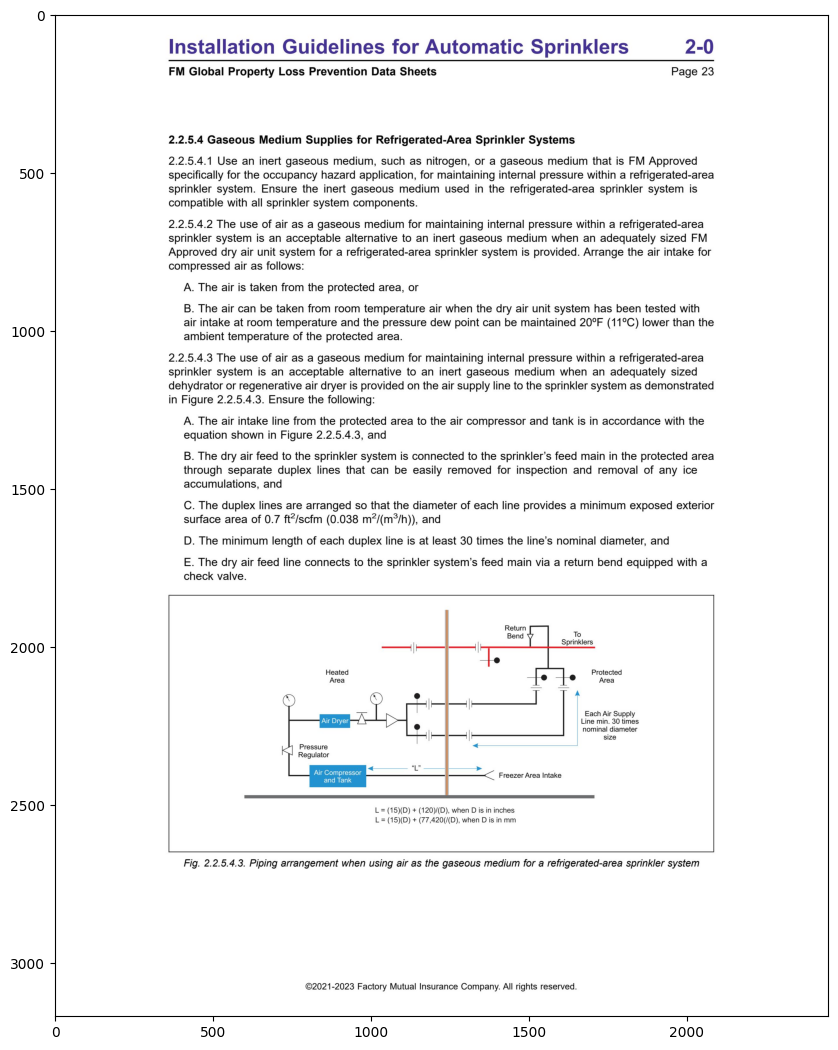

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
#
rcParams['figure.figsize'] = 13 ,13
image = plt.imread('page_22.jpg')
plt.imshow(image)
plt.show()

### Now lets call the vision's service's Image Analysis API
### to perform OCR

#### There are a lot of options possible with the Vision Service
#### I will just use the base model with no options

In [9]:
import os
import azure.ai.vision as sdk

#service_options = sdk.VisionServiceOptions(os.environ["AZURE_VISION_ENDPOINT"],
#                                           os.environ["AZURE_VISION_KEY"])

# This can be called for a local file or a URL
# I am using a local file
vision_source = sdk.VisionSource(filename="page_22.jpg")
#
# if using a URL
# below is how I would contruct the location
# vision_source = sdk.VisionSource(
#     url="https://learn.microsoft.com/azure/ai-services/computer-vision/media/quickstarts/presentation.png")
#
analysis_options = sdk.ImageAnalysisOptions()

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT
)

analysis_options.language = "en"

analysis_options.gender_neutral_caption = True

image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)

result = image_analyzer.analyze()

if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:

    if result.caption is not None:
        print(" Caption:")
        print("   '{}', Confidence {:.4f}".format(result.caption.content, result.caption.confidence))

    if result.text is not None:
        print(" Text:")
        for line in result.text.lines:
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            for word in line.words:
                points_string = "{" + ", ".join([str(int(point)) for point in word.bounding_polygon]) + "}"
                print("     Word: '{}', Bounding polygon {}, Confidence {:.4f}"
                      .format(word.content, points_string, word.confidence))

else:

    error_details = sdk.ImageAnalysisErrorDetails.from_result(result)
    print(" Analysis failed.")
    print("   Error reason: {}".format(error_details.reason))
    print("   Error code: {}".format(error_details.error_code))
    print("   Error message: {}".format(error_details.message))

 Caption:
   'a document with text and diagrams', Confidence 0.6122
 Text:
   Line: 'Installation Guidelines for Automatic Sprinklers', Bounding polygon {358, 67, 1825, 67, 1825, 135, 358, 135}
     Word: 'Installation', Bounding polygon {360, 70, 685, 69, 684, 134, 359, 134}, Confidence 0.9570
     Word: 'Guidelines', Bounding polygon {708, 69, 1038, 68, 1038, 134, 707, 134}, Confidence 0.9950
     Word: 'for', Bounding polygon {1057, 68, 1149, 68, 1149, 135, 1057, 135}, Confidence 0.9980
     Word: 'Automatic', Bounding polygon {1162, 68, 1479, 68, 1480, 135, 1162, 135}, Confidence 0.9950
     Word: 'Sprinklers', Bounding polygon {1493, 68, 1811, 68, 1812, 136, 1494, 135}, Confidence 0.9940
   Line: '2-0', Bounding polygon {1981, 71, 2089, 70, 2089, 132, 1979, 131}
     Word: '2-0', Bounding polygon {1986, 70, 2080, 70, 2080, 132, 1986, 132}, Confidence 0.9980
   Line: 'FM Global Property Loss Prevention Data Sheets', Bounding polygon {354, 152, 1207, 152, 1207, 203, 354, 203}
     W

## Exploring what was returned in the Result
### Notice I can get properties like:
#### Image height: 3168
#### Image width: 2447
#### Model version: 2023-02-01-preview
#### a Caption:  'a document with text and diagrams'
#### a Confidence 0.6122
#### and line by line the text for that Line: and also each word in that line
#### and bounding boxes coordinates for everything

For a full description of what is available 
see: https://learn.microsoft.com/en-us/python/api/azure-ai-vision/azure.ai.vision.imageanalysisresultdetails?view=azure-python-preview  


In [10]:
if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:

    print(" Image height: {}".format(result.image_height))
    print(" Image width: {}".format(result.image_width))
    print(" Model version: {}".format(result.model_version))

    if result.caption is not None:
        print(" Caption:")
        print("   '{}', Confidence {:.4f}".format(result.caption.content, result.caption.confidence))

    if result.dense_captions is not None:
        print(" Dense Captions:")
        for caption in result.dense_captions:
            print("   '{}', {}, Confidence: {:.4f}".format(caption.content, caption.bounding_box, caption.confidence))

    if result.objects is not None:
        print(" Objects:")
        for object in result.objects:
            print("   '{}', {}, Confidence: {:.4f}".format(object.name, object.bounding_box, object.confidence))

    if result.tags is not None:
        print(" Tags:")
        for tag in result.tags:
            print("   '{}', Confidence {:.4f}".format(tag.name, tag.confidence))

    if result.people is not None:
        print(" People:")
        for person in result.people:
            print("   {}, Confidence {:.4f}".format(person.bounding_box, person.confidence))

    if result.crop_suggestions is not None:
        print(" Crop Suggestions:")
        for crop_suggestion in result.crop_suggestions:
            print("   Aspect ratio {}: Crop suggestion {}"
                  .format(crop_suggestion.aspect_ratio, crop_suggestion.bounding_box))

    if result.text is not None:
        print(" Text:")
        for line in result.text.lines:
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            for word in line.words:
                points_string = "{" + ", ".join([str(int(point)) for point in word.bounding_polygon]) + "}"
                print("     Word: '{}', Bounding polygon {}, Confidence {:.4f}"
                      .format(word.content, points_string, word.confidence))

    result_details = sdk.ImageAnalysisResultDetails.from_result(result)
    print(" Result details:")
    print("   Image ID: {}".format(result_details.image_id))
    print("   Result ID: {}".format(result_details.result_id))
    print("   Connection URL: {}".format(result_details.connection_url))
    print("   JSON result: {}".format(result_details.json_result))

else:

    error_details = sdk.ImageAnalysisErrorDetails.from_result(result)
    print(" Analysis failed.")
    print("   Error reason: {}".format(error_details.reason))
    print("   Error code: {}".format(error_details.error_code))
    print("   Error message: {}".format(error_details.message))

 Image height: 3168
 Image width: 2447
 Model version: 2023-02-01-preview
 Caption:
   'a document with text and diagrams', Confidence 0.6122
 Text:
   Line: 'Installation Guidelines for Automatic Sprinklers', Bounding polygon {358, 67, 1825, 67, 1825, 135, 358, 135}
     Word: 'Installation', Bounding polygon {360, 70, 685, 69, 684, 134, 359, 134}, Confidence 0.9570
     Word: 'Guidelines', Bounding polygon {708, 69, 1038, 68, 1038, 134, 707, 134}, Confidence 0.9950
     Word: 'for', Bounding polygon {1057, 68, 1149, 68, 1149, 135, 1057, 135}, Confidence 0.9980
     Word: 'Automatic', Bounding polygon {1162, 68, 1479, 68, 1480, 135, 1162, 135}, Confidence 0.9950
     Word: 'Sprinklers', Bounding polygon {1493, 68, 1811, 68, 1812, 136, 1494, 135}, Confidence 0.9940
   Line: '2-0', Bounding polygon {1981, 71, 2089, 70, 2089, 132, 1979, 131}
     Word: '2-0', Bounding polygon {1986, 70, 2080, 70, 2080, 132, 1986, 132}, Confidence 0.9980
   Line: 'FM Global Property Loss Prevention Data S

## Notice the text from the diagram on the page is also returned

In [18]:
start_flag=0
if result.text is not None:
    print(" Text:")
    for line in result.text.lines:
        if line.content.startswith("check valve."):
            start_flag=1
        if start_flag==1:
            print(line.content)
        if line.content.startswith("Fig. 2.2"):
            start_flag=0

 Text:
check valve.
Return
Bend
To
Sprinklers
Heate
Protected
Area
Area
Air Drye
Each Air Supply
Line min. 30 times
nominal diameter
size
Pressure
Regulator
Air Compressor
"L'
and Tank
Freezer Area Intake
L=(15)(D) + (120)/(D), when D is in inches
L = (15)(D) + (77,420(/(D), when D is in mm
Fig. 2.2.5.4.3. Piping arrangement when using air as the gaseous medium for a refrigerated-area sprinkler system


## Easy way to get all text content
### Use the json_result obtained from:  
### result_details = sdk.ImageAnalysisResultDetails.from_result(result)

In [28]:
import json
# The API Returned result
# in previous cell I called the following
# result_details = sdk.ImageAnalysisResultDetails.from_result(result)
# which returns a json string that I can parse as below
#
json_result=json.loads(result_details.json_result)
print(json_result["readResult"]["content"])


Installation Guidelines for Automatic Sprinklers
2-0
FM Global Property Loss Prevention Data Sheets
Page 23
2.2.5.4 Gaseous Medium Supplies for Refrigerated-Area Sprinkler Systems
2.2.5.4.1 Use an inert gaseous medium, such as nitrogen, or a gaseous medium that is FM Approved
specifically for the occupancy hazard application, for maintaining internal pressure within a refrigerated-area
sprinkler system. Ensure the inert gaseous medium used in the refrigerated-area sprinkler system is
compatible with all sprinkler system components.
2.2.5.4.2 The use of air as a gaseous medium for maintaining internal pressure within a refrigerated-area
sprinkler system is an acceptable alternative to an inert gaseous medium when an adequately sized FM
Approved dry air unit system for a refrigerated-area sprinkler system is provided. Arrange the air intake for
compressed air as follows:
A. The air is taken from the protected area, or
B. The air can be taken from room temperature air when the dry air uni

## Can the Vision Service detect the diagram?

When we called the API the first time we only asked for two options by setting the analysis_options.features  

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT
    )

### lets try some additional options

In [57]:
import os
import azure.ai.vision as sdk

#service_options = sdk.VisionServiceOptions(os.environ["AZURE_VISION_ENDPOINT"],
#                                           os.environ["AZURE_VISION_KEY"])

# This can be called for a local file or a URL
# I am using a local file
vision_source = sdk.VisionSource(filename="page_22.jpg")
#

analysis_options = sdk.ImageAnalysisOptions()

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT |
    sdk.ImageAnalysisFeature.OBJECTS |
    sdk.ImageAnalysisFeature.TAGS |
    sdk.ImageAnalysisFeature.CROP_SUGGESTIONS |
    #sdk.ImageAnalysisFeature.FACES |
    sdk.ImageAnalysisFeature.DENSE_CAPTIONS |
    sdk.ImageAnalysisFeature.PEOPLE 
)

analysis_options.language = "en"
analysis_options.gender_neutral_caption = True
# Call the API
image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)
result = image_analyzer.analyze()

    
    

In [58]:
if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:
    if result.people is not None:
        if len(result.people) !=0:
            print(" People were found in the image")
    if result.objects is not None:
        if len(result.objects) !=0:
            print(" Objects were found in the image")
    if result.tags is not None:
        if len(result.tags) !=0:
            print(" Tags were found in the image")
    if result.segmentation_result is not None:
        if len(result.segmentation_result) !=0:
            print(" segmentation_results were found in the image")
    if result.dense_captions is not None:
        if len(result.dense_captions) !=0:
            print(" dense_captions were found in the image")
    if result.crop_suggestions is not None:
        if len(result.crop_suggestions) !=0:
            print(" crop_suggestions were found in the image")
print("done!")


 Objects were found in the image
 Tags were found in the image
 dense_captions were found in the image
 crop_suggestions were found in the image
done!


### Exploring those further we see that the API does see the following:
 'diagram of a compressor and air compressor'
 
 and it sees it within this Rectangle's coordinates:
 (x=324, y=1807, w=1768, h=843)
 
 With a Confidence: 0.6306

In [44]:
if result.dense_captions is not None:
    print(" Dense Captions:")
    for caption in result.dense_captions:
        print("   '{}', {}, Confidence: {:.4f}".format(caption.content, caption.bounding_box, caption.confidence))

if result.objects is not None:
    print(" Objects:")
    for object in result.objects:
        print("   '{}', {}, Confidence: {:.4f}".format(object.name, object.bounding_box, object.confidence))

if result.tags is not None:
    print(" Tags:")
    for tag in result.tags:
        print("   '{}', Confidence {:.4f}".format(tag.name, tag.confidence))

if result.people is not None:
    print(" People:")
    for person in result.people:
        print("   {}, Confidence {:.4f}".format(person.bounding_box, person.confidence))

if result.crop_suggestions is not None:
    print(" Crop Suggestions:")
    for crop_suggestion in result.crop_suggestions:
        print("   Aspect ratio {}: Crop suggestion {}"
                .format(crop_suggestion.aspect_ratio, crop_suggestion.bounding_box))

 Dense Captions:
   'a document with text and diagrams', Rectangle(x=0, y=0, w=2447, h=3168), Confidence: 0.6122
   'diagram of a compressor and air compressor', Rectangle(x=324, y=1807, w=1768, h=843), Confidence: 0.6306
   'a diagram of a system', Rectangle(x=238, y=19, w=1897, h=2782), Confidence: 0.5620
   'a blue text on a white background', Rectangle(x=341, y=10, w=1701, h=153), Confidence: 0.7740
   'a white text with black text', Rectangle(x=352, y=1369, w=1698, h=369), Confidence: 0.6568
   'a close-up of a black text', Rectangle(x=353, y=1328, w=1726, h=152), Confidence: 0.7025
   'a white background with black text', Rectangle(x=361, y=1607, w=1706, h=150), Confidence: 0.7213
 Objects:
   'text', Rectangle(x=387, y=185, w=1804, h=2368), Confidence: 0.6460
 Tags:
   'text', Confidence 1.0000
   'screenshot', Confidence 0.9750
   'font', Confidence 0.9421
   'document', Confidence 0.8994
   'number', Confidence 0.8949
 People:
 Crop Suggestions:
   Aspect ratio 0.77: Crop sugg

In [45]:
for caption in result.dense_captions:
    print(caption.content)

a document with text and diagrams
diagram of a compressor and air compressor
a diagram of a system
a blue text on a white background
a white text with black text
a close-up of a black text
a white background with black text


## Draw the rectangle onto the page

Unlike we saw with coordinated returned from the layout API when analyzing a PDF,
when analyzing an image the coordinates are in pixels so no conversion is needed

397.0 2663.0 2043.0 2664.0 2043.0 2703.0 397.0 2703.0
***************************************************************
diagrams bottom left = 324,1807 and diagrams bottom right = 2092,1807 
diagrams top left = 324,2650 and diagrams top right = 2092,2650 
titles bottom left = 397.0,2663.0 and titles bottom right = 2043.0,2664.0 
titles top left = 397.0,2703.0 and titles top right = 2043.0,2703.0 
397.0 2663.0 2043.0 2664.0 2043.0 2703.0 397.0 2703.0


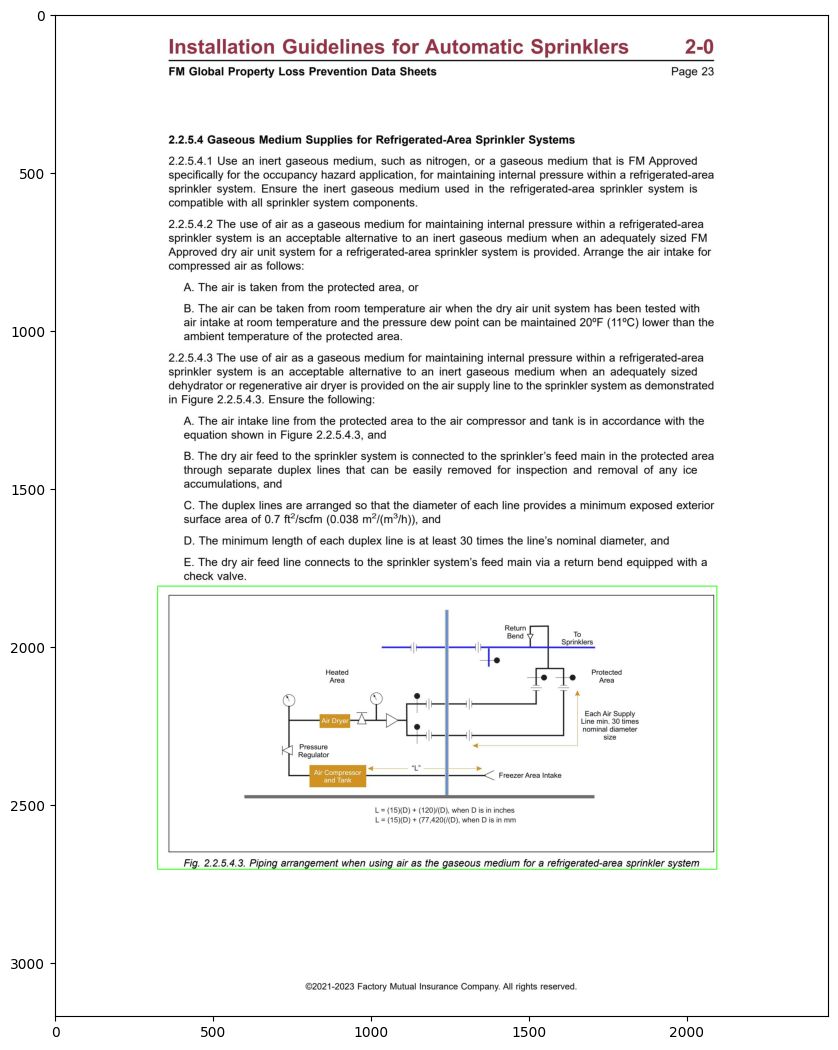

In [119]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
image = cv2.imread("page_22.jpg")

# lets first find the lines that start with "Fig. "
# They will be the line below the diagram
figure_titles_found=[]
for line in result.text.lines:
    if line.content is not None:
        if line.content.startswith("Fig. "):
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            #print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            # line.bounding_polygon is a list with 8 values
            figure_titles_found.append(line.bounding_polygon)
# loop through and draw the rectangles around the titles
# captions represent the rectangle where the diagram may be
for caption in result.dense_captions:
    if caption.content.find("diagram")>-1:
        rect = caption.bounding_box
        # draw the rectangle
        x, y, w, h = rect.x, rect.y, rect.w, rect.h
        # We  dont want any 0,0s
        if x==0 and y==0:
            continue
        # the lowest y coordinate of the diagram should be greater than the y coordinate of the caption
        # lets use the bottom left coordinate of the line content
        title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3  = figure_titles_found[0]
        print(title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3)
        # These come back starting with the top left and going clockwise
        #
        #                      x0, y0-------> x1, y1
        #                        |               |
        #                        |               |
        #                      x3, y3<------- x2, y2
        #
        #
        #
        # titles represent the totle of the diagram that appreas directly below the diagram
        # compare the y coordinate of the caption ("y") to the y coordinate of the bottom left point of the title 
        # If the title's top y is greater than the caption's top y , the title would be above the diagram not below
        # that is wrong so we dont want it
        if y+h >= title_y0:
            continue
        # If the title's bottom y is greater than the caption's bottom y , the title would be inside the diagram not below
        # that is wrong so we dont want it
        if y >= title_y3:
            continue
        # so now we should have good ones left
        pt1=(x,y)
        pt2=(x+w,y+h)
        print("***************************************************************")
        print("diagrams bottom left = {},{} and diagrams bottom right = {},{} ".format( x,y,x+w,y))
        print("diagrams top left = {},{} and diagrams top right = {},{} ".format( x,y+h,x+w,y+h))
        print("titles bottom left = {},{} and titles bottom right = {},{} ".format( title_x0, title_y0 , title_x1, title_y1))
        print("titles top left = {},{} and titles top right = {},{} ".format( title_x3, title_y3 , title_x2, title_y2))
        #
        #if we use  the titles bottom y when drawing the green box we will get the title in the image too
        # create a new point using the title bottom right coordinates
        # avoid the error: name 'point' is not defined
        # the box must go aroung the title which is below the diagram
        title_left_top_corner=(int(title_x3), int(title_y3))
        title_right_top_corner=(int(title_x2),int(title_y2))
        title_right_bottom_corner=(int(title_x1), int(title_y1))
        title_left_bottom_corner=(int(title_x0), int(title_y0))
        # draw the rectangle around the diagram and the title
        # so the top of the rectangle to draw will use the diagrams top y
        # and use the titles bottom y
        x_top_left = int(min(title_x3,x))
        y_top_left = int(max(title_y3,y+h))
        x_bottom_right = int(max(title_x1,x+w))
        y_bottom_right = int(min(title_y1,y))
        # draw the rectangle
        cv2.rectangle(image,(x_top_left,y_top_left),(x_bottom_right,y_bottom_right),(36,255,12),2)
        #cv2.rectangle(image,pt1,title_right_bottom_corner,(0,255,0),3)

# show the image
plt.figure(figsize=(13,13))
plt.imshow(image)
plt.show()


## Lets save the diagram  to disk

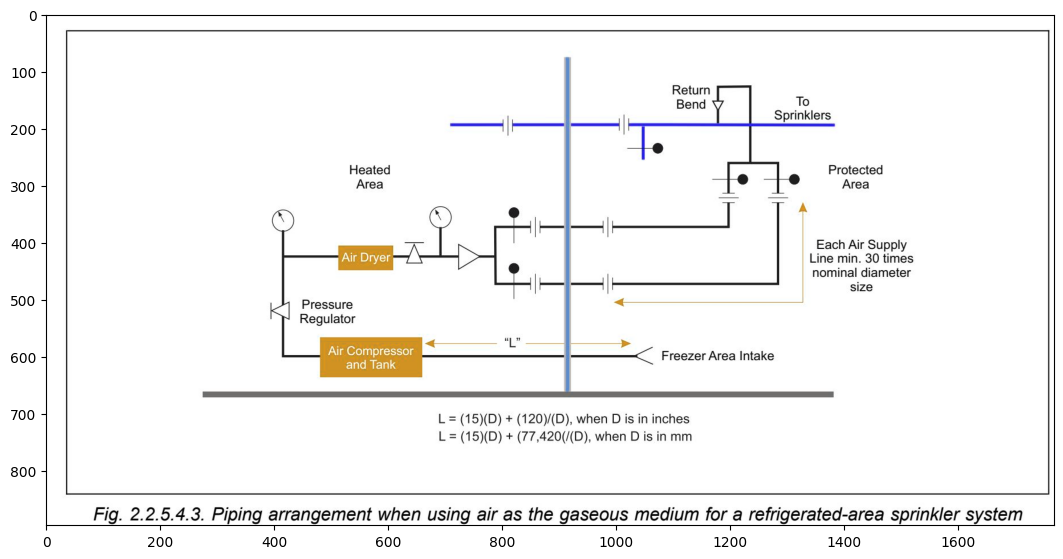

In [125]:
def cutout_image_around_both(image, result):
    # call the function to do the cutouts
    # always pass in a single image (of the page)
    # and the result from the API
    cutouts=[]
    titles_to_keep=[]
    figure_titles_found=[]
    for line in result.text.lines:
        if line.content is not None:
            if line.content.startswith("Fig."):
                points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
                #print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
                # line.bounding_polygon is a list with 8 values
                figure_titles_found.append(line.bounding_polygon)
                mystart=line.content.find(" ")
                myend=line.content.find(" ", mystart+1)
                title_to_keep=line.content[mystart+1:myend]
                title_to_keep=title_to_keep[:-1]
                titles_to_keep.append(title_to_keep)
    # loop through and draw the rectangles around the titles
    # captions represent the rectangle where the diagram may be
    for caption in result.dense_captions:
        if caption.content.find("diagram")>-1:
            rect = caption.bounding_box
            # draw the rectangle
            x, y, w, h = rect.x, rect.y, rect.w, rect.h
            # We  dont want any 0,0s
            if x==0 and y==0:
                continue
            # the lowest y coordinate of the diagram should be greater than the y coordinate of the caption
            # lets use the bottom left coordinate of the line content
            title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3  = figure_titles_found[0]
            # Note that this come in starting with the top left and going clockwise
            #
            # titles represent the totle of the diagram that appreas directly below the diagram
            # compare the y coordinate of the caption ("y") to the y coordinate of the bottom left point of the title 
            # If the title's top y is greater than the caption's top y , the title would be above the diagram not below
            # that is wrong so we dont want it
            if y+h >= title_y0:
                continue
            # If the title's bottom y is greater than the caption's bottom y , the title would be inside the diagram not below
            # that is wrong so we dont want it
            if y >= title_y3:
                continue
            # so now we should have good ones left
            #
            #if we use  the titles bottom y when drawing the green box we will get the title in the image too
            # create a new point using the title bottom right coordinates
            # avoid the error: name 'point' is not defined
            # the box must go aroung the title which is below the diagram
            title_left_top_corner=(int(title_x3), int(title_y3))
            title_right_top_corner=(int(title_x2),int(title_y2))
            title_right_bottom_corner=(int(title_x1), int(title_y1))
            title_left_bottom_corner=(int(title_x0), int(title_y0))
            # draw the rectangle around the diagram and the title
            # so the top of the rectangle to draw will use the diagrams top y
            # and use the titles bottom y
            min_x= int(min(title_x3,x))
            max_y = int(max(title_y3,y+h))
            max_x = int(max(title_x1,x+w))
            min_y = int(min(title_y1,y))
            # draw the rectangle
            cutout_image=image[min_y:max_y, min_x:max_x]
            cutouts.append(cutout_image)   
    # return the cutout images
    return cutouts, titles_to_keep


# main code
import cv2 
import matplotlib.pyplot as plt
from matplotlib import rcParams
#
image = cv2.imread("page_22.jpg")
cutouts_out, titles_to_keep = cutout_image_around_both(image, result)
#
# Now lets loop through the images and save them to disk
for image in cutouts_out:
    for title in titles_to_keep:
        # save it to disk
        final_title="Figure " + title + ".png"
        # write it to disk
        cv2.imwrite(str(final_title), image)
# loop through and show the images
for img in cutouts_out:
    plt.figure(figsize=(13,13))
    plt.imshow(img)
    plt.show()